import packages

In [2]:
import SciNN as s
import numpy as np
import os
from IPython.display import clear_output
import copy
import random
import csv
import matplotlib.pyplot as plt


set factors

In [3]:
INPUT_COLOR_DIMENSION = 3  # 변경하면 안됨
INPUT_ENV_DIMENSION = 1
OUPUT_MOVEMENT_DIMENSION = 2  # 변경하면 안됨
OUPUT_IRRELAVENT_DIMENSION = 1

INTERNAL_NEURON_LENGTH = 20
TRAIN_EPOCH = 1 #400
TEST_EPOCH = 0 #100
INPUT_ENV_VOLATILITY = 0.01

LIGHT_EXPOSURE_TIME = 1 #10
WAITING_TIME = 2 #20

RED_COLOR_EXPOSURE_PROB = 1/3
BLUE_COLOR_EXPOSURE_PROB = 1/3 # < 1 - RED_COLOR_EXPOSURE_PROB

CORRECT_LOSS_LIMIT = 0.05

SAVE_LEARNING_HISTORY_FILE_NAME = "output"
SAVE_HEATMAP_FILE_NAME = "output_heatmap"

if not os.path.isdir(f"output/{SAVE_HEATMAP_FILE_NAME}"):
    os.mkdir(f"output/{SAVE_HEATMAP_FILE_NAME}")

set new PANN model

In [4]:
output_length = OUPUT_MOVEMENT_DIMENSION + OUPUT_IRRELAVENT_DIMENSION
input_ext_length = INPUT_COLOR_DIMENSION + INPUT_ENV_DIMENSION
input_length = input_ext_length + output_length

a = s.SciNN(input_length)
a.addLayer(INTERNAL_NEURON_LENGTH)
a.addLayer(output_length)
a.initializeWeight()
a.setActivationFunction("tanh")
a.setLossFunction("mse")

AttributeError: module 'SciNN' has no attribute 'PANN'

set random input-target generating function

In [ ]:
temp_red_prob = RED_COLOR_EXPOSURE_PROB - (1-RED_COLOR_EXPOSURE_PROB-BLUE_COLOR_EXPOSURE_PROB)/25
temp_blue_prob = BLUE_COLOR_EXPOSURE_PROB - (1-RED_COLOR_EXPOSURE_PROB-BLUE_COLOR_EXPOSURE_PROB)/25

def generateFn():
    p = random.random()
    if p < temp_red_prob:
        return {"input_color": [1-random.random()/3, random.random()/3, random.random()/3], "target_vector": [1,0]}
    elif p < temp_red_prob + temp_blue_prob:
        return {"input_color": [random.random()/3, random.random()/3, 1-random.random()/3], "target_vector": [0,1]}
    else:
        input_color = [random.random(), random.random(), random.random()]
        target_vector = []
        if input_color[0] > 2/3 and input_color[1] < 1/3 and input_color[2] < 1/3:
            target_vector = [1,0]
        elif input_color[0] < 1/3 and input_color[1] < 1/3 and input_color[2] > 2/3:
            target_vector = [0,1]
        else:
            target_vector = [0,0]
        return {"input_color": input_color, "target_vector": target_vector}

activate model

In [ ]:

input_color = []
input_env = [random.random() for env in range(INPUT_ENV_DIMENSION)]
# t-L-1 ~ t-1 범위의 과거 output 저장
output_vector_list_prev = [[0 for i in range(output_length)] for l in range(a.layer_depth+1)]
f = open(f"output/{SAVE_LEARNING_HISTORY_FILE_NAME}.csv","w",encoding="utf-8",newline="")
wr = csv.writer(f)
wr.writerow(["no", "iteration", "input_color", "input_env", "time", "loss", "success", "correct_count"])

for ep in range(TRAIN_EPOCH + TEST_EPOCH):
    input_target_sample = generateFn()
    input_color = [random.random() for color in range(INPUT_COLOR_DIMENSION)]
    correct_count = 0
    feed_stopped = False
    
    for t in range(LIGHT_EXPOSURE_TIME + WAITING_TIME):
        output_vector_prev = output_vector_list_prev.pop(0)
        input_env = [input_env[env] + 2*random.random()*INPUT_ENV_VOLATILITY - INPUT_ENV_VOLATILITY for env in range(INPUT_ENV_DIMENSION)]
        
        if t < LIGHT_EXPOSURE_TIME:
            input_vector = [*input_target_sample["input_color"], *input_env, *output_vector_prev]
        else:
            input_vector = [*[0 for color in range(INPUT_COLOR_DIMENSION)], *input_env, *output_vector_prev]
        
        target_vector = input_target_sample["target_vector"]
        
        a._propagateForward(input_vector)
        
        if a.lossFn(a.h[-1],[*target_vector, *a.h[-1][OUPUT_MOVEMENT_DIMENSION:]]) < CORRECT_LOSS_LIMIT:
            if correct_count > LIGHT_EXPOSURE_TIME:
                feed_stopped = True
            else:
                correct_count += 1
                    
        if not feed_stopped and ep < TRAIN_EPOCH:
            a._propagateBackward([*target_vector, *a.h[-1][OUPUT_MOVEMENT_DIMENSION:]])
            
        s.printAfterErase(f"iteration : {ep+1}; time : {t+1} ; loss : {a.lossFn(a.h[-1],[*target_vector, *a.h[-1][OUPUT_MOVEMENT_DIMENSION:]])}     ")
        wr.writerow([ep*(LIGHT_EXPOSURE_TIME + WAITING_TIME)+t+1,
                     ep+1,
                     target_vector[0]+2*target_vector[1], # none: 0, r: 1, b: 2
                     input_env[0],
                     t+1,
                     a.lossFn(a.h[-1],[*target_vector, *a.h[-1][OUPUT_MOVEMENT_DIMENSION:]]),
                     1 if feed_stopped else 0,
                     correct_count
                     ])
        a.saveHeatmap(f"output/{SAVE_HEATMAP_FILE_NAME}/{s.fillZero(ep*(LIGHT_EXPOSURE_TIME + WAITING_TIME)+t+1,5)}.png")
        output_vector_list_prev.append(copy.deepcopy(a.h[-1]))

f.close()
print("\nDone")
# clear_output()

iteration : 1; time : 3 ; loss : 0.29889920070662573     
Done


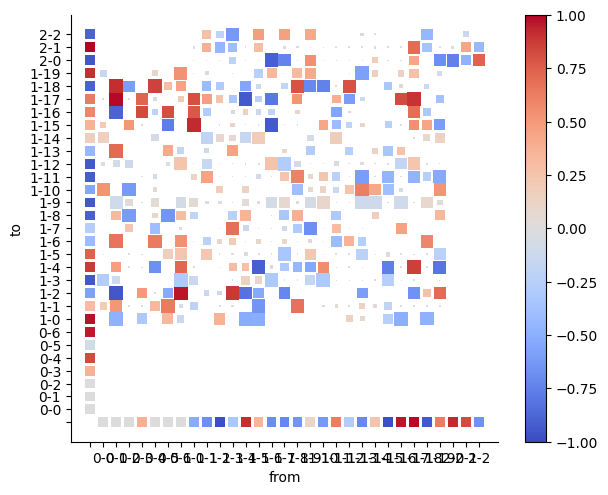

In [ ]:
a.drawHeatmap()

In [ ]:
a.W, a.h

([[[-6.846441137343563e-05,
    0.9142739142236638,
    -0.000533989297567236,
    0.6042057760896397,
    -1.8526545300195547e-06,
    -0.6078408135872949,
    0.272507816309539,
    -0.0007452096230508195,
    2.8273379617409873e-05,
    -0.6839976048980227,
    -0.0008112601858643347,
    0.9896674061915134,
    0.9665404221935483,
    0.00025456262982398263,
    0.0003568830530915738,
    -0.0007837798903853476,
    0.00010004436996833324,
    -0.00033950036902582163,
    0.00010670306497028192,
    -0.26355062672504653,
    -0.1323745532135579,
    -0.0005486691547906809,
    0.48649301593300015,
    0.9389316294008941,
    -0.0006545075294528411,
    0.9055486004097355,
    -0.0004161544711818216],
   [-0.2633904607187084,
    -0.741895889900574,
    -0.02774713415430196,
    -0.014817042669607042,
    -0.4812912465341417,
    -0.9284602590153831,
    0.09223076866098567,
    0.3252590144009061,
    -0.000716018722596076,
    -0.01484689332043199,
    -0.02972114031235356,
    -0

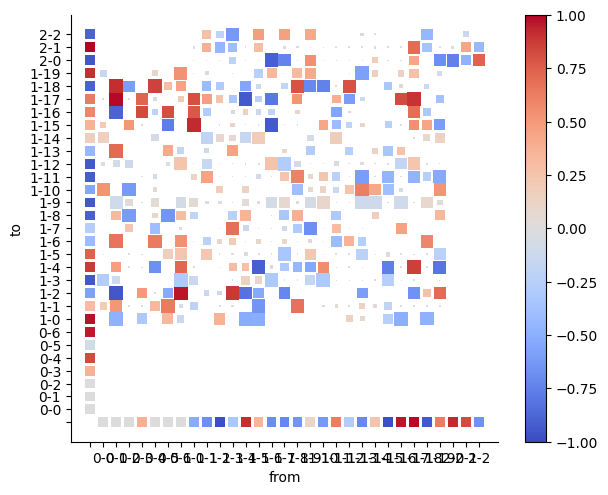

In [ ]:
a.saveHeatmap("output/temp.png")